# Diabetes prediction

## This project was done to represent how Machine Learning techniques can used for making predictive models
## The dataset is taken from Kaggle from the National Institute of Diabetes and Digestive and Kidney Diseases.
## https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database

### Project was finished by Gadelshin Egor (GitHub: Akori-Music)

### Part 00.
#### Data predprocessing

In [1]:
# Improting necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
%matplotlib inline

In [2]:
# Importing the dataset and depicting first 5 rows
df=pd.read_csv('diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
# Recognizing dataset's shape (rows, columns)
df.shape

(768, 9)

In [4]:
# Showing a list of columns and their type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [5]:
# Basic statistical description
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [6]:
# Looking up for any duplicated values
df.duplicated().sum()

0

<Axes: >

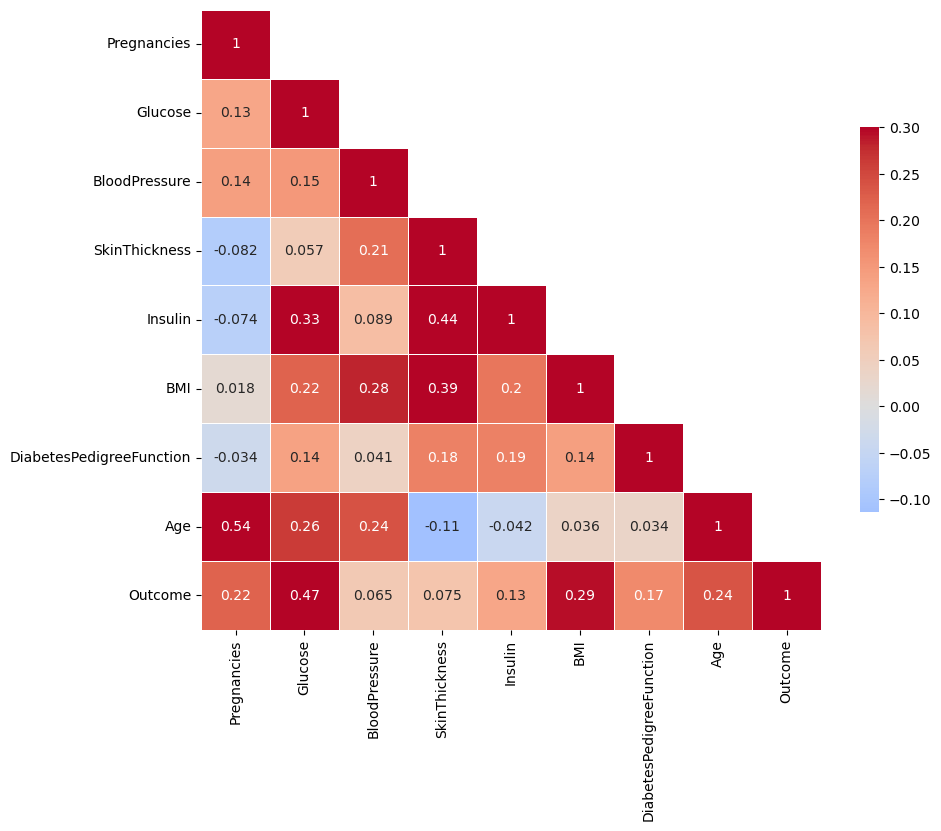

In [7]:
# Let us observe the correlation of the variables and see if the relationship between them is high
# The value of 1 and -1 represent full positive and negative correlation, while 0 represents no correlation at all
# This helps understanding how much the values depend on each other and helps seeing their potential importance in the model
c=df.corr()
plt.figure(figsize=(10, 10))
mask = np.triu(np.ones_like(c, dtype=bool), k=1)
sns.heatmap(c, mask=mask, cmap='coolwarm', vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={'shrink': .5}, annot=True)

#### Through the heatmap we can se a relatively high correlaton betwee age and pregnancies, which is expectable, but does not bear high importance. The Outcome values are much more interesting to look at in our case. As such, the highest value is in Glucose (which is sugar), which is also understandable, as the higher the sugar is, the higher the chance of getting diabetes gets.

Text(0.5, 1.0, 'Outcome')

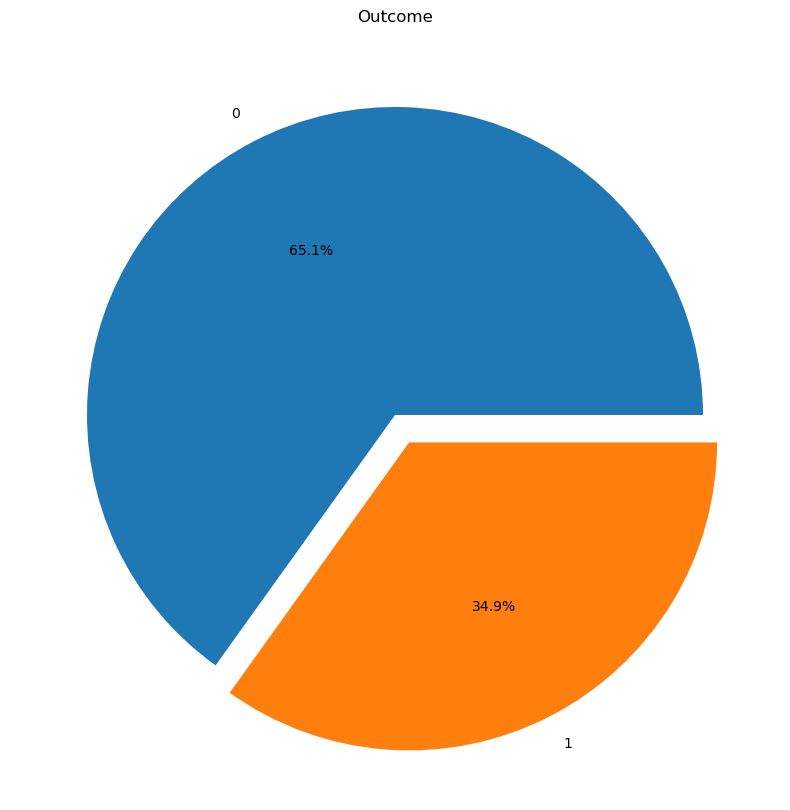

In [8]:
# Let us use pie chart to see the distribution of the "Outcome value"
c=df['Outcome'].value_counts()
plt.figure(figsize=(10, 10))
plt.pie(c,explode=[0, 0.1], autopct='%1.1f%%',labels=[0,1])
plt.title("Outcome")

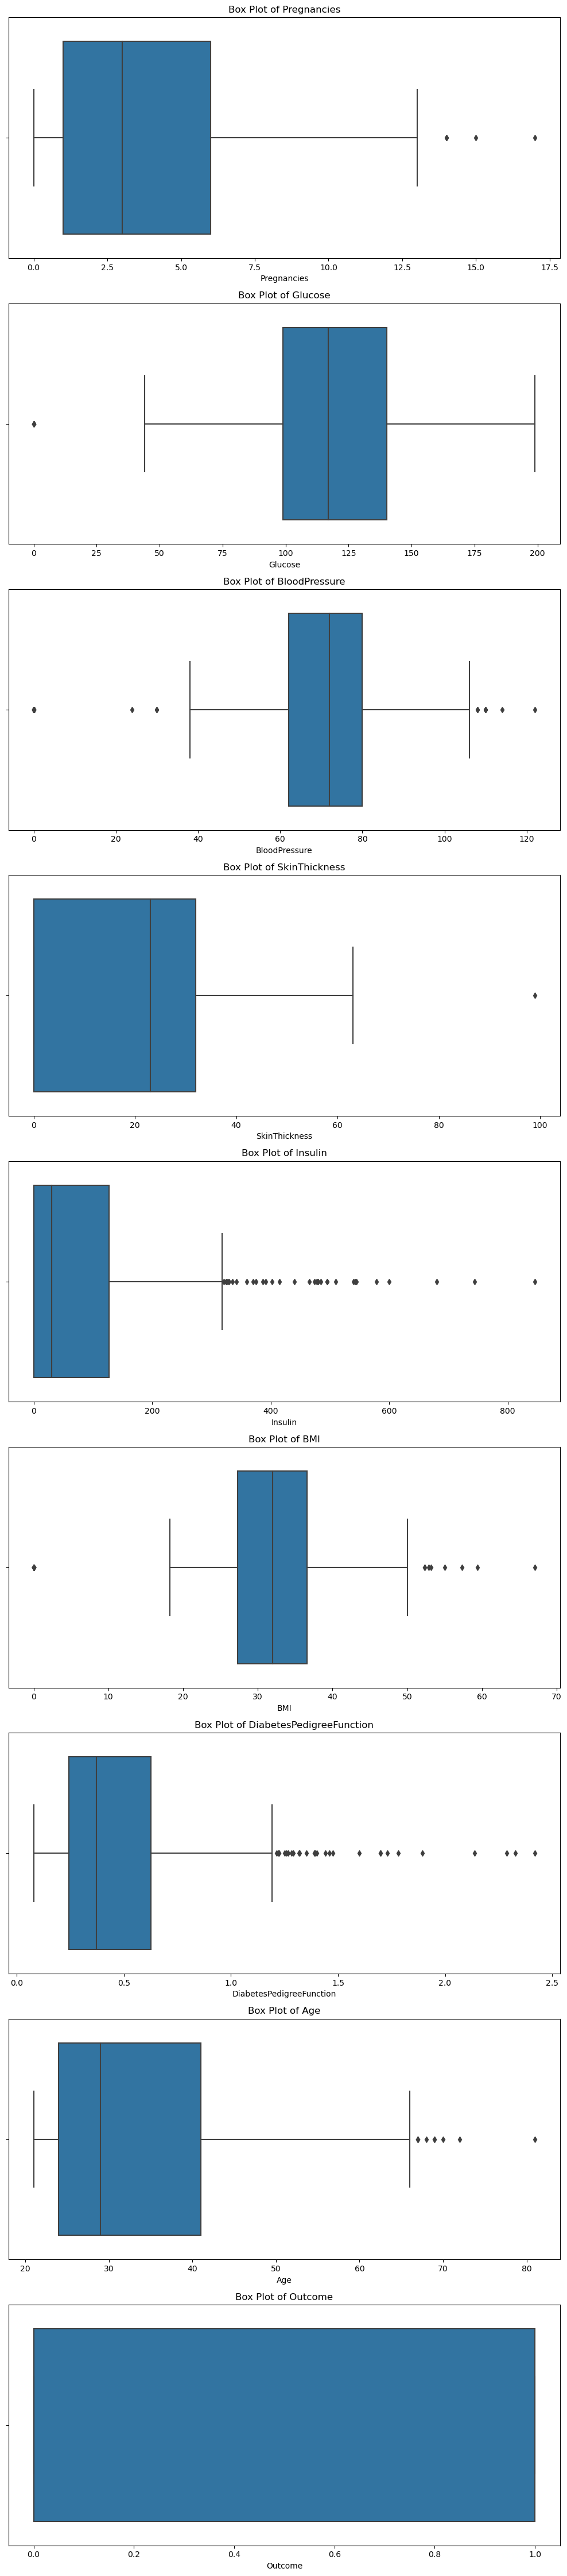

In [9]:
# Let us create box plots to see which ranges do features belong to and see if scaling is required
fig, axes = plt.subplots(nrows=len(df.columns), ncols=1, figsize=(10, 5 * len(df.columns)))
for i, column in enumerate(df.columns):
    sns.boxplot(x=df[column], ax=axes[i])
    axes[i].set_title(f'Box Plot of {column}')

plt.tight_layout()
plt.show()

##### Features are in different ranges which requires scaling them

Text(0.5, 1.0, 'Missing values in the dataset')

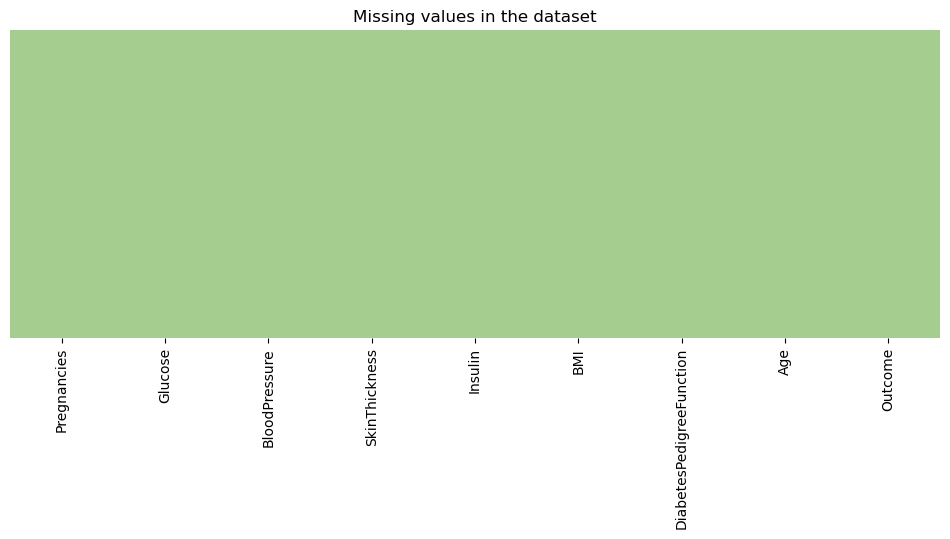

In [10]:
# Looking for missing values
plt.figure(figsize=(12,4))
sns.heatmap(df.isnull(), cbar=False, cmap='crest', yticklabels=False)
plt.title('Missing values in the dataset')

##### The dataset does not include missing values, however, there are 0 values of BMI, Blood pressure and Glucose, which is pravctically impossible, therefore rows with 0 vlause shoud be dealt with

In [11]:
x=df.columns
for col in x:
    num_zeros=df[col].eq(0).sum()
    print(num_zeros," in ",col)
    
    

111  in  Pregnancies
5  in  Glucose
35  in  BloodPressure
227  in  SkinThickness
374  in  Insulin
11  in  BMI
0  in  DiabetesPedigreeFunction
0  in  Age
500  in  Outcome


In [12]:
# Replacing meaningless zeros
def filling_zeroes(df, cols): 
    for col in cols:
        med = df.groupby('Outcome')[col].transform('median')
        zero_mask = df[col] == 0
        df.loc[zero_mask & (df['Outcome'] == 0), col] = med[zero_mask & (df['Outcome'] == 0)]
        df.loc[zero_mask & (df['Outcome'] == 1), col] = med[zero_mask & (df['Outcome'] == 1)]
    return df
df = filling_zeroes(df.copy(), df.columns[1:8])
df 

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,39,26.6,0.351,31,0
2,8,183,64,27,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,39,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,27,0,30.1,0.349,47,1


### Part 02.
#### Logistic Regression Modeling

In [13]:
features=df.drop('Outcome',axis=1)
target=df['Outcome']

In [14]:
stds=StandardScaler()
x_train,x_test,y_train,y_test =train_test_split(features,target,test_size=0.20,random_state=6)

In [15]:
lr = LogisticRegression(random_state=42,max_iter=17000)
pipe_line=make_pipeline(stds,lr)
pipe_line

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(max_iter=17000, random_state=42))])

In [16]:
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8246753246753247


### Part 03.
#### Playing With hyperparameters

In [17]:
# Creating a function to train on C-value
def train_and_evaluate(C, solver):
    lr = LogisticRegression(C=C, solver=solver, random_state=42)
    pipe_line2=make_pipeline(stds,lr)
    pipe_line2.fit(x_train, y_train)

 
    y_pred = pipe_line2.predict(x_test)


    accuracy = accuracy_score(y_test, y_pred)
    return accuracy


In [18]:
C_values = [0.00001,0.0001,0.001, 0.01, 0.1, 1, 10,100,1000,10000]
solver_options = ['lbfgs', 'newton-cg','sag','liblinear']

for C in C_values:
      for solver in solver_options:
        accuracy = train_and_evaluate(C, solver)
        print(f"C={C}  , solver='{solver}'    : Accuracy = {accuracy}")


C=1e-05  , solver='lbfgs'    : Accuracy = 0.6688311688311688
C=1e-05  , solver='newton-cg'    : Accuracy = 0.6688311688311688
C=1e-05  , solver='sag'    : Accuracy = 0.6688311688311688
C=1e-05  , solver='liblinear'    : Accuracy = 0.7467532467532467
C=0.0001  , solver='lbfgs'    : Accuracy = 0.6688311688311688
C=0.0001  , solver='newton-cg'    : Accuracy = 0.6688311688311688
C=0.0001  , solver='sag'    : Accuracy = 0.6688311688311688
C=0.0001  , solver='liblinear'    : Accuracy = 0.7467532467532467
C=0.001  , solver='lbfgs'    : Accuracy = 0.6818181818181818
C=0.001  , solver='newton-cg'    : Accuracy = 0.6818181818181818
C=0.001  , solver='sag'    : Accuracy = 0.6818181818181818
C=0.001  , solver='liblinear'    : Accuracy = 0.7597402597402597
C=0.01  , solver='lbfgs'    : Accuracy = 0.8051948051948052
C=0.01  , solver='newton-cg'    : Accuracy = 0.8051948051948052
C=0.01  , solver='sag'    : Accuracy = 0.8051948051948052
C=0.01  , solver='liblinear'    : Accuracy = 0.7727272727272727


In [19]:
# Assigning Random Forest Classifier
rf=RandomForestClassifier()

In [20]:
rf.fit(x_train,y_train)

RandomForestClassifier()

In [21]:
rf.score(x_train,y_train)

1.0

In [22]:
rf_acc=rf.score(x_test,y_test)
print("Accuracy:", rf_acc)

Accuracy: 0.9025974025974026


In [23]:
# Retraining Logistic Regression
clf = LogisticRegression(C=1.10, penalty='l1', solver='liblinear', random_state=42)
clf.fit(x_train, y_train)

LogisticRegression(C=1.1, penalty='l1', random_state=42, solver='liblinear')

In [24]:
y_pred2 = clf.predict(x_test)

In [25]:
lr_acc = accuracy_score(y_test, y_pred2)
print("Accuracy:", lr_acc)

Accuracy: 0.8181818181818182


In [26]:
arr=[rf_acc*100,lr_acc*100]

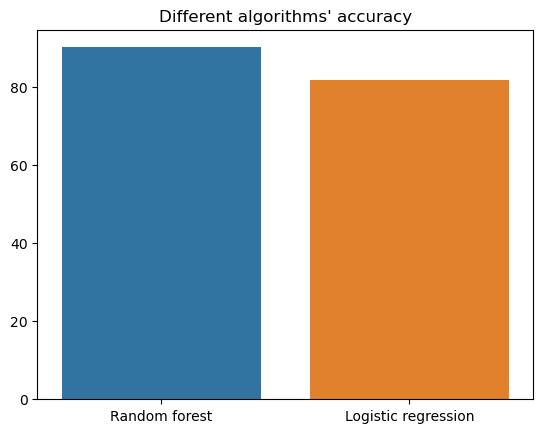

In [27]:
# Comparing the models
sns.barplot(y=arr,x=['Random forest','Logistic regression'])
plt.title("Different algorithms' accuracy")
plt.show()

### Through this project, we were able to create a predictive model using Logistic Regression and uccessfully increased its accuracy up to 89.6%